438/438 [==============================] - 2s 4ms/step


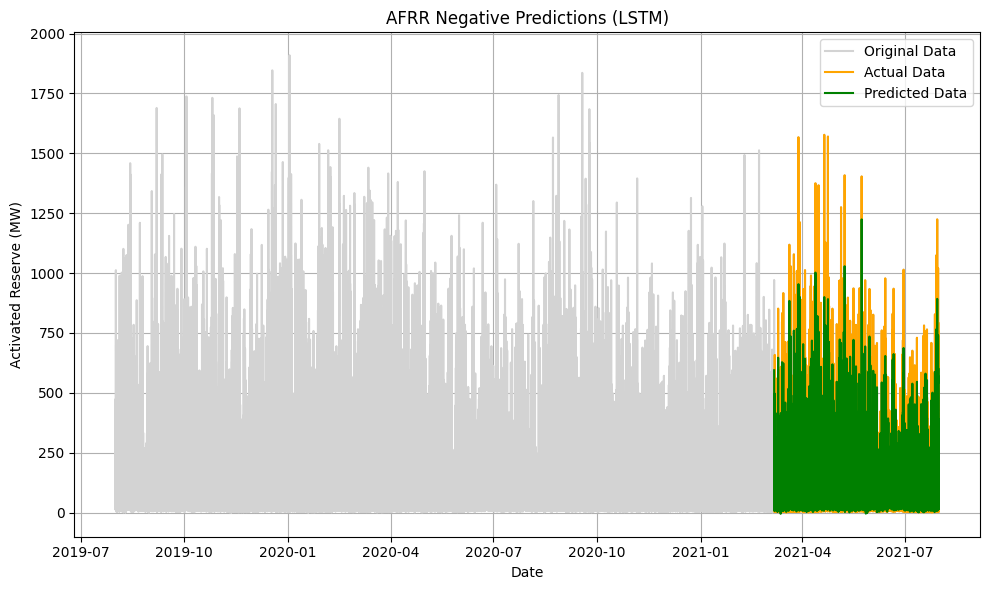

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load and prepare the dataset
df = pd.read_csv(r'C:\Users\dvouk\Desktop\Dtu\Thesis_pre\Thesis_project\ols_linear_regression\frr_data.csv', sep=';', decimal=',')

df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
df['date'] = pd.to_datetime(df['date'], utc=True, format='ISO8601')
df['date'] = df['date'].dt.tz_convert('CET').dt.tz_localize(None)

# Drop rows with missing AFRR values
df = df.dropna(subset=['AFRR_DE_NEG'])

# Normalize target
scaler = MinMaxScaler()
df['scaled_afrr'] = scaler.fit_transform(df[['AFRR_DE_NEG']])

# Create sequences for LSTM
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 10
X, y = create_sequences(df['scaled_afrr'].values, window_size)

# Train/test split
split_point = int(len(X) * 0.8)
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(window_size, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, verbose=0)

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform to get actual values
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Dates for plotting
plot_dates = df['date'][window_size + split_point:]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['AFRR_DE_NEG'], label='Original Data', color='lightgray')
plt.plot(plot_dates, y_test_inv.flatten(), label='Actual Data', color='orange')
plt.plot(plot_dates, y_pred_inv.flatten(), label='Predicted Data', color='green')

plt.title('AFRR Negative Predictions (LSTM)')
plt.xlabel('Date')
plt.ylabel('Activated Reserve (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
import pandas as pd

df = pd.read_csv(r'C:\Users\dvouk\Desktop\Dtu\Thesis_pre\Thesis_project\ols_linear_regression\frr_data.csv', sep=';', decimal=',')


In [7]:
# find the rmse from the test set 
from sklearn.metrics import mean_squared_error
from math import sqrt

# Predict on training set
train_pred = model.predict(X_train)

# Since y_train and train_pred are scaled, flatten train_pred for comparison
train_rmse = np.sqrt(np.mean((y_train - train_pred.flatten()) ** 2))
print(f'Training RMSE: {train_rmse:.2f}')


1752/1752 [==============================] - 7s 4ms/step
Training RMSE: 0.07


In [8]:
# find the rmse from the test set
test_rmse = np.sqrt(np.mean((y_test - y_pred.flatten()) ** 2))
print(f'Test RMSE: {test_rmse:.2f}')


Test RMSE: 0.07
